# Data

## AWID3 Dataset

AWID3 dataset consists of 13 captures of traffic in a wireless network. Of these 7 that focus on attacks on IEEE 802.11 MAC layer. The attacks chosen are: 

* Deauth
* Disass
* (Re)Assoc
* RogueAP
* Krack
* Kr00k
* Evil Twin

## Data preprocessing

For training of the model 

Features selection was based on [Pick Quality Over Quantity: Expert Feature Selection and Data Preprocessing for 802.11 Intrusion Detection Systems](https://ieeexplore.ieee.org/document/9797689) by the authors of the AWID3 dataset:

### Features chosen by Chatzoglou et. al. and their preprocessing

| Feature                    | Preprocessing    |
|----------------------------|------------------|
| frame.len                  | Min-Max Scaling  |
| radiotap.len               | Min-Max Scaling  |
| radiotap.dbm_antsignal     | Min-Max Scaling  |
| wlan.duration              | Min-Max Scaling  |
| radiotap.present.tsft      | One Hot Encoding |
| radiotap.channel.freq      | One Hot Encoding |
| radiotap.channel.type.cck  | One Hot Encoding |
| radiotap.channel.type.ofdm | One Hot Encoding |
| wlan.fc.type               | One Hot Encoding |
| wlan.fc.subtype            | One Hot Encoding |
| wlan.fc.ds                 | One Hot Encoding |
| wlan.fc.frag               | One Hot Encoding |
| wlan.fc.retry              | One Hot Encoding |
| wlan.fc.pwrmgt             | One Hot Encoding |
| wlan.fc.moredata           | One Hot Encoding |
| wlan.fc.protected          | One Hot Encoding |

The chosen features were prepocessed with following differences:
* frame.delta_time was was was added, as it is crucial for analyzing temproal patterns.
* features expressed by 0/1 values, such as IEEE 802.11 Frame Control flags were left unchanged (e.g. frag, retry), not One Hot Encoded as in above mentioned article.
* the authors  One Hot Encoding of channel frequencies, however such approach is only feasable, when there rather few categories (3 frequencies were used in the above mentioned files), so a more genral method of preprocessing frequncy is proposed:
    * create two binary features `2ghz_spectrum` and `5ghz_spectrum` to indicate in which band a frame was sent
    * apply Min-Max Scaling to frequency, using the highest and the lowest channel frequency in given band as Min and Max values, as seen below

In [1]:
def preporcess_frequency(radiotap_channel_freq):
    lower_2ghz, higer_2ghz = 2412, 2472
    lower_5ghz, higher_5gzh = 5160, 5885
    
    if (lower_2ghz <= radiotap_channel_freq <= higer_2ghz):
        _2ghz_spectrum = 1
        _5gzh_spectrum = 0
        freq = (radiotap_channel_freq - lower_2ghz) / (higer_2ghz - lower_2ghz)
    elif (lower_5ghz <= radiotap_channel_freq <= higer_5ghz):
        _2ghz_spectrum = 0
        _5gzh_spectrum = 1
        freq = (radiotap_channel_freq - lower_5ghz) / (higer_5ghz - lower_5ghz)
    else:
        _2ghz_spectrum = 0
        _5gzh_spectrum = 0
        freq = -1
        
    return _2ghz_spectrum, _5gzh_spectrum, freq
     

### Features and used preprocessing

| Feature                   | Type        | Preprocessing       | Values                    | Description                                                                                                       |
|---------------------------|-------------|---------------------|---------------------------|-------------------------------------------------------------------------------------------------------------------|
| frame.len                 | numeric     | Min-Max Scaling     | from 70 to 3220           | Length of frame, in bytes                                                                                         |
| frame.time_delta          | numeric     | Min-Max Scaling     | from 0 to 0.001817        | Time interval since previous frame, in seconds                                                                    |
| radiotap.len              | numeric     | Min-Max Scaling     | from 48 to 64             | Length of Radiotap header, in bytes                                                                               |
| radiotap.dbm_antsignal    | numeric     | Min-Max Scaling     | form -255 to -78          | Strength of recieved signal, in dBm. In AWID3 CSV files the value was summarized for antennas, hence very low values |
| wlan.duration             | numeric     | Min-Max Scaling     | from 0 to 726             | Duration/Id field in IEEE 802.11 header                                                                           |
| wlan.fc.type              | categorical | One Hot Encoding    | 0, 1, 2                   | IEEE 802.11 frame type: Management, Control or Data                                                               |
| wlan.fc.subtype           | categorical | One Hot Encoding    | 0, 1, ... 14, 15          | IEEE 802.11 frame subtype                                                                                         |
| wlan.fc.ds                | categorical | One Hot Encoding    | 0, 1, 2, 3                | Indicates whete a frame was sent to (tods) or from (fromds) a Distribution System (ds), neither or both           |
| radiotap.present.tsft     | binary      | convert to 0,1      | '0-0-0', '1-0-0'          | Presence of TSFT (Time Synchroniztion Function) in Radiotap header                                                |
| radiotap.channel.type.cck | binary      | None                | 0, 1                      | Whether frame was sent using CCK (Complemantary Code Keying), used in IEEE 802.11b                                |
| radiotap.channel.type.ofdm | binary     | None                | 0, 1                      | Whether frame was sent using OFDM (Orthognal Frequency Division Multiplexing) modulation                          |
| wlan.fc.frag              | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame was fragmented                                                         |
| wlan.fc.retry             | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame is retransmission of a previous frame                                  |
| wlan.fc.pwrmgt            | binary      | None                | 0, 1                      | Frame Control flag, used when station enters power management state                                               |
| wlan.fc.moredata          | binary      | None                | 0, 1                      | Frame Control flag, indicates that AP has buffered for the station                                                |
| wlan.fc.protected         | binary      | None                | 0, 1                      | Frame Control flag, indicates that frame has been encrypted                                                       |
| 2ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 2.4GHz band                                                               |
| 5ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 5GHz band                                                                 |
| freq                      | numeric     | As described above  | from 0 to 1               | Frequency scaled for the band station works in                                                                    |
| Label                     | Categorical | Convert to 0, 1, 2  | 'Normal' and attacks      | Label of given to the frame                                                                                      | 

Minimal and maximal values for ranges were estimated accros all AWID3 files, IQR was used to exckude otliers, that were then clipped into range 0, 1.

The traffic was divided into 3 classes:

Classes:

| Class | name           | Attacks                                                               |
|-------|----------------|-----------------------------------------------------------------------|
| 0     | normal         |                                                                       |
| 1     | flooding       | Deauth, Disass, (Re)Assoc, Kr00k                                      |
| 2     | impersonation  | RogueAP, Krack, Evil Twin                                             |

Both binary, and multiclass classificators were trained and evaluated on the dataset.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np

tfrecords_dir='dataset/AWID3_tfrecords'
tfrecords_balanced_dir='dataset/AWID3_tfrecords_balanced'

sequence_length = 32
sequence_shift = 30
n_features = 39

E0000 00:00:1732232780.184423   54731 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732232780.190413   54731 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import data_utils

files = os.listdir(tfrecords_dir)

train_ratio = 0.8
train_files, test_files = data_utils.train_test_split(files, train_ratio=train_ratio)
train_files, val_files = data_utils.train_test_split(train_files, train_ratio=train_ratio)

print("Training set:")
for t in train_files:
    print(t.split('.')[0], end=', ')

print("\nValidation set:")
for t in val_files:
    print(t.split('.')[0], end=', ')

print("\nTest set:")
for t in test_files:
    print(t.split('.')[0], end=', ')
    
train_seq_files = [os.path.join(tfrecords_dir, f) for f in train_files]
val_seq_files = [os.path.join(tfrecords_dir, f) for f in val_files]
test_seq_files = [os.path.join(tfrecords_dir, f) for f in test_files]
train_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in train_files]
val_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in val_files]
test_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in test_files]



Training set:
Disas_35, RogueAP_27, (Re)Assoc_32, Deauth_31, Kr00k_55, Evil_Twin_75, (Re)Assoc_35, Krack_25, Kr00k_53, (Re)Assoc_28, Evil_Twin_70, Evil_Twin_62, (Re)Assoc_27, Evil_Twin_54, Evil_Twin_65, Kr00k_56, RogueAP_29, Evil_Twin_50, Disas_37, Kr00k_39, Disas_36, Evil_Twin_33, Kr00k_36, RogueAP_33, RogueAP_39, (Re)Assoc_24, (Re)Assoc_34, Evil_Twin_47, RogueAP_37, Disas_39, (Re)Assoc_25, Deauth_29, Kr00k_43, Kr00k_48, Deauth_32, Evil_Twin_74, Deauth_27, Disas_28, Kr00k_35, Kr00k_51, Deauth_21, Evil_Twin_48, RogueAP_31, Evil_Twin_73, Kr00k_46, Evil_Twin_29, Evil_Twin_72, Evil_Twin_67, Disas_40, Evil_Twin_57, (Re)Assoc_31, Disas_31, Disas_29, RogueAP_28, Evil_Twin_37, Evil_Twin_69, Kr00k_44, Evil_Twin_43, Krack_26, Evil_Twin_41, Deauth_25, Evil_Twin_71, Evil_Twin_40, (Re)Assoc_26, RogueAP_24, Deauth_24, Kr00k_54, Evil_Twin_60, Kr00k_34, RogueAP_26, Evil_Twin_46, Kr00k_40, RogueAP_25, Evil_Twin_30, Evil_Twin_61, Deauth_23, Evil_Twin_63, RogueAP_35, Evil_Twin_53, Evil_Twin_32, Evil_Twi

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import seaborn as sns

def score_and_confusion_matrix(y_pred, y_true, title : str, binary = True, average='binary'):
    class_names = [
        'Normal', 'Attack'
    ] if binary else [
        'Normal', 'Flooding', 'Impersonation'
    ]
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 : {f1:.4f}')
    print(f'Kappa: {kappa:.4f}')
    
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: ' + title)
    plt.show()
    
    return accuracy, precision, recall, f1, kappa
    
def plot_model_history(history, title):
    
    plt.title(title)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    if 'accuracy' in history:
        axes[0, 0].plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            axes[0, 0].plot(history['val_accuracy'], label='Val Accuracy')
        axes[0, 0].set_title('Accuracy')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_ylim(0.8, 1)
        axes[0, 0].legend()
    
    # Plot Precision
    if 'precision' in history:
        axes[0, 1].plot(history['precision'], label='Train Precision')
        if 'val_precision' in history:
            axes[0, 1].plot(history['val_precision'], label='Val Precision')
        axes[0, 1].set_title('Precision')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].set_ylim(0.8, 1)
        axes[0, 1].legend()
    
    if 'recall' in history:
        axes[1, 0].plot(history['recall'], label='Train Recall')
        if 'val_recall' in history:
            axes[1, 0].plot(history['val_recall'], label='Val Recall')
        axes[1, 0].set_title('Recall')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Recall')
        axes[1, 0].set_ylim(0.8, 1)
        axes[1, 0].legend()
    
    if 'loss' in history:
        axes[1, 1].plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            axes[1, 1].plot(history['val_loss'], label='Val Loss')
        axes[1, 1].set_title('Loss')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()    
    plt.tight_layout()
    plt.show()
        

In [5]:
import binary_cnn_lstm
import data_utils

bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()

if not bin_cnn_lstm_model.built:
    bin_train_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files)
    bin_val_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)
    history = bin_cnn_lstm_model.fit(
        train_seq_ds,
        validation_data=val_seq_ds,
        epochs=30,
        callbacks=[bin_cnn_lstm_model.checkpoint_callback]
    )
    plot_model_history(history.history)
    #loading best checkpoint
    bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()
    
    
bin_cnn_lstm_model.summary()


I0000 00:00:1732232784.013375   54731 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4909 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Model loaded from saved_models/binary_cnn_lstm.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 128)      │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 128)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 32)       │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 32)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, None, 1)        │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624,581 (2.38 MB)

 Trainable params: 208,193 (813.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 416,388 (1.59 MB)

I0000 00:00:1732232866.430117   54861 cuda_dnn.cc:529] Loaded cuDNN version 90300


414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Accuracy: 0.9985
Precision: 0.9928
Recall: 0.9993
F1 Score: 0.9960


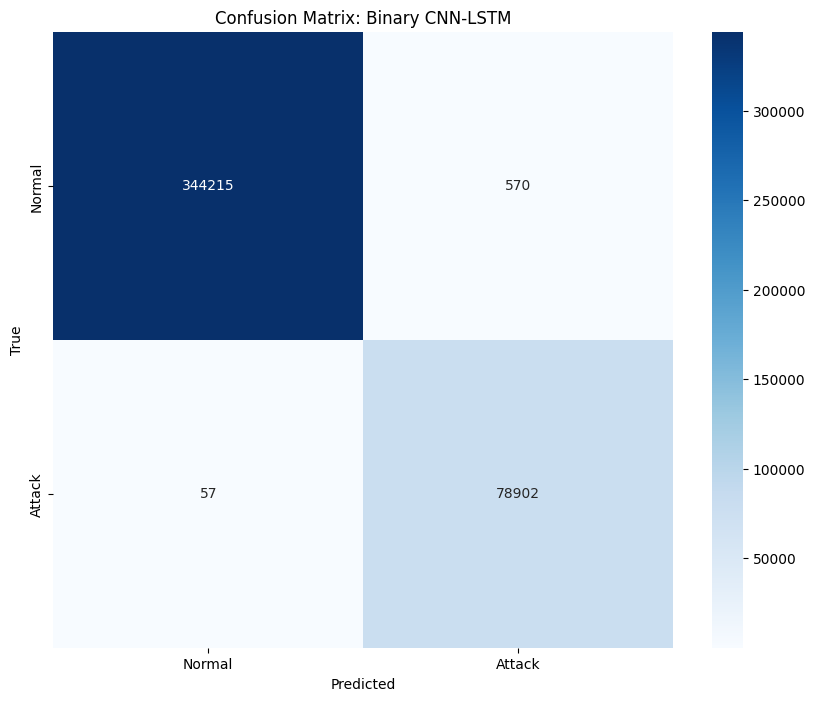

In [6]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_lstm_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn_lstm_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary CNN-LSTM")


Epoch 1/50


I0000 00:00:1732232874.869361   54863 service.cc:148] XLA service 0x55a7e6a1d9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732232874.869388   54863 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1


     26/Unknown 8s 4ms/step - accuracy: 0.5605 - loss: 1.1646 - precision: 0.5404 - recall: 0.8843

I0000 00:00:1732232879.117696   54863 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  11920/Unknown 55s 4ms/step - accuracy: 0.5239 - loss: 1.1716 - precision: 0.5147 - recall: 0.8319

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.49954, saving model to saved_models/binary_cnn1d.keras
11920/11920 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - accuracy: 0.5239 - loss: 1.1716 - precision: 0.5147 - recall: 0.8319 - val_accuracy: 0.4995 - val_loss: 1.1668 - val_precision: 0.4998 - val_recall: 0.9990
Epoch 2/50
11908/11920 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5356 - loss: 1.1605 - precision: 0.5223 - recall: 0.8400
Epoch 2: val_accuracy did not improve from 0.49954
11920/11920 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.5356 - loss: 1.1605 - precision: 0.5223 - recall: 0.8400 - val_accuracy: 0.4987 - val_loss: 1.1550 - val_precision: 0.4994 - val_recall: 0.9974
Epoch 3/50
11907/11920 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5485 - loss: 1.1491 - precision: 0.5303 - recall: 0.8477
Epoch 3: val_accuracy did not improve from 0.49954
11920/11920 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.5485 - loss: 1.1491 - precision: 0.5303 - recall: 0.8477 - val_accuracy: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 128)         │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,573 (220.99 KB)

 Trainable params: 18,857 (73.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 37,716 (147.33 KB)

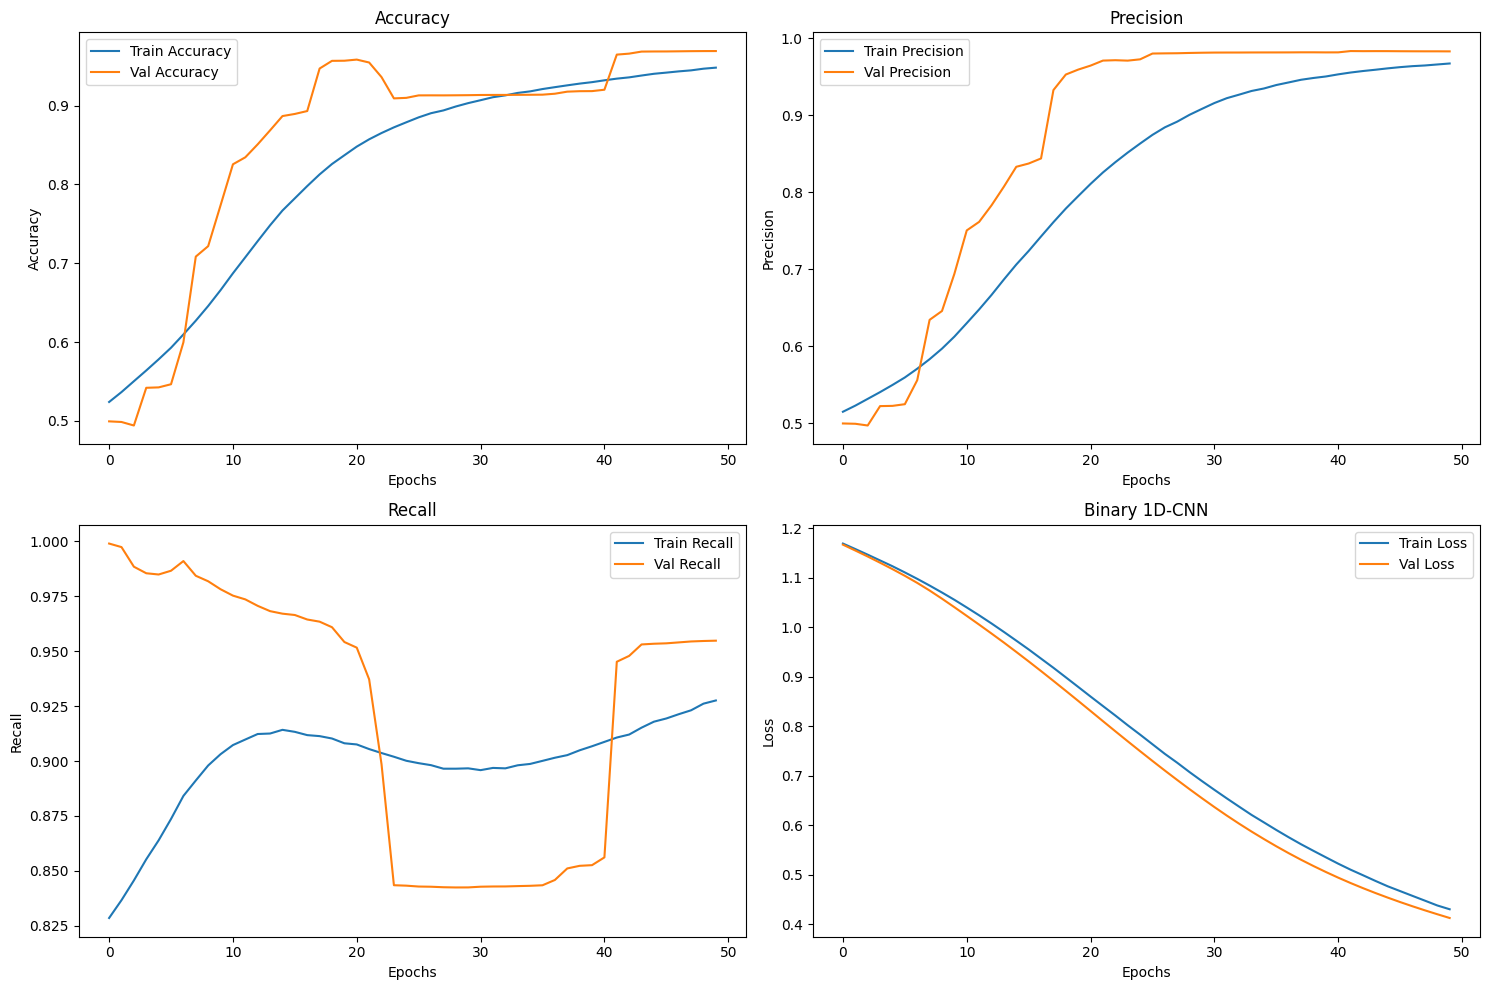

In [7]:
import binary_cnn1d
import data_utils

bin_cnn1d_model = binary_cnn1d.binary_CNN1D_model()

if not bin_cnn1d_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_cnn1d_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=30,
            callbacks = [binary_cnn1d.checkpoint_callback],
        )
    print(history.history)
    bin_cnn1d_model.summary()
    plot_model_history(history.history, 'Binary 1D-CNN')
else:
    pass



4628/4628 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Accuracy: 0.9750
Precision: 0.9884
Recall: 0.9612
F1 Score: 0.9746


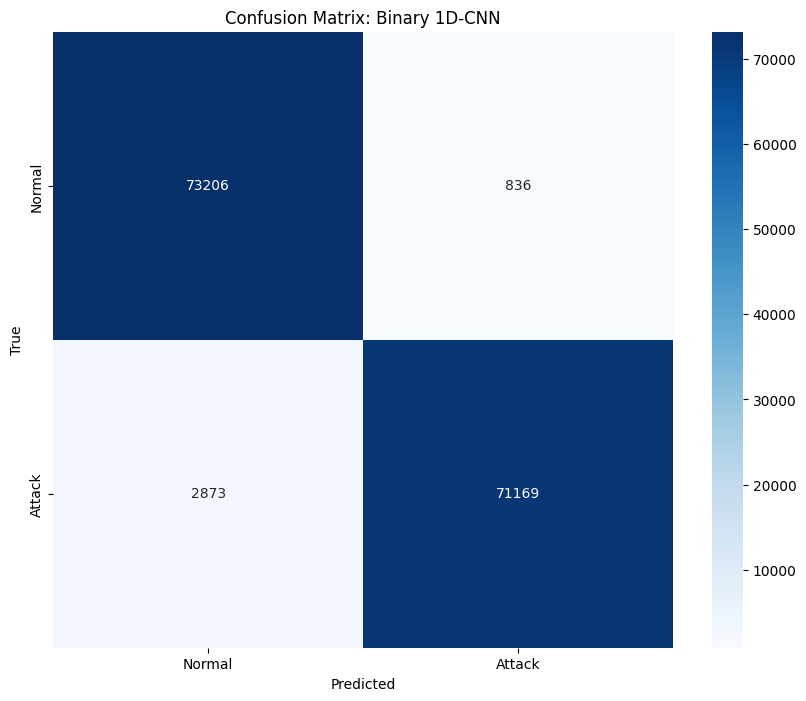

In [8]:
binary_bal_test_ds = data_utils.create_binary_dataset(test_bal_files)
features = []
labels = []

for x, y in binary_bal_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn1d_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn1d_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary 1D-CNN')


Epoch 1/50
  11920/Unknown 51s 4ms/step - accuracy: 0.9822 - loss: 0.0622 - precision: 0.9837 - recall: 0.9804

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from 0.96922 to 0.99526, saving model to saved_models/binary_cnn1d.keras
11920/11920 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.9822 - loss: 0.0622 - precision: 0.9837 - recall: 0.9804 - val_accuracy: 0.9953 - val_loss: 0.0130 - val_precision: 0.9906 - val_recall: 1.0000
Epoch 2/50
11918/11920 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9967 - loss: 0.0189 - precision: 0.9958 - recall: 0.9976
Epoch 2: val_accuracy did not improve from 0.99526
11920/11920 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.9967 - loss: 0.0189 - precision: 0.9958 - recall: 0.9976 - val_accuracy: 0.9926 - val_loss: 0.0208 - val_precision: 0.9950 - val_recall: 0.9902
Epoch 3/50
11909/11920 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9969 - loss: 0.0163 - precision: 0.9960 - recall: 0.9979
Epoch 3: val_accuracy improved from 0.99526 to 0.99773, saving model to saved_models/binary_cnn1d.keras
11920/11920 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9969 - loss: 0.016

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 30)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,396 (21.08 KB)

 Trainable params: 2,613 (10.21 KB)

 Non-trainable params: 168 (672.00 B)

 Optimizer params: 2,615 (10.22 KB)

{'accuracy': [0.992684543132782, 0.9966040253639221, 0.9968758225440979, 0.9970419406890869, 0.9971392154693604, 0.9971375465393066, 0.9971845746040344, 0.9972432851791382, 0.9974378943443298, 0.9974043369293213, 0.997421145439148, 0.9974261522293091, 0.9973506331443787, 0.9974899291992188, 0.997463047504425, 0.9974261522293091, 0.997452974319458, 0.997406005859375, 0.9975906014442444, 0.9974429607391357, 0.997322142124176, 0.9974647760391235, 0.9971258044242859, 0.9972717761993408, 0.9969580173492432, 0.9972382187843323, 0.9974228143692017, 0.9975083470344543, 0.9974983334541321, 0.997619092464447, 0.997478187084198, 0.9972835183143616, 0.9967969655990601, 0.9972969889640808, 0.9974949359893799, 0.9975368976593018, 0.9975419044494629, 0.9975654482841492, 0.9976593852043152, 0.9976224899291992, 0.9975234866142273, 0.9975972771644592, 0.9975637197494507, 0.9975268244743347, 0.9974697828292847, 0.9975922703742981, 0.9975906014442444, 0.9978020191192627, 0.9975889325141907, 0.997481524944

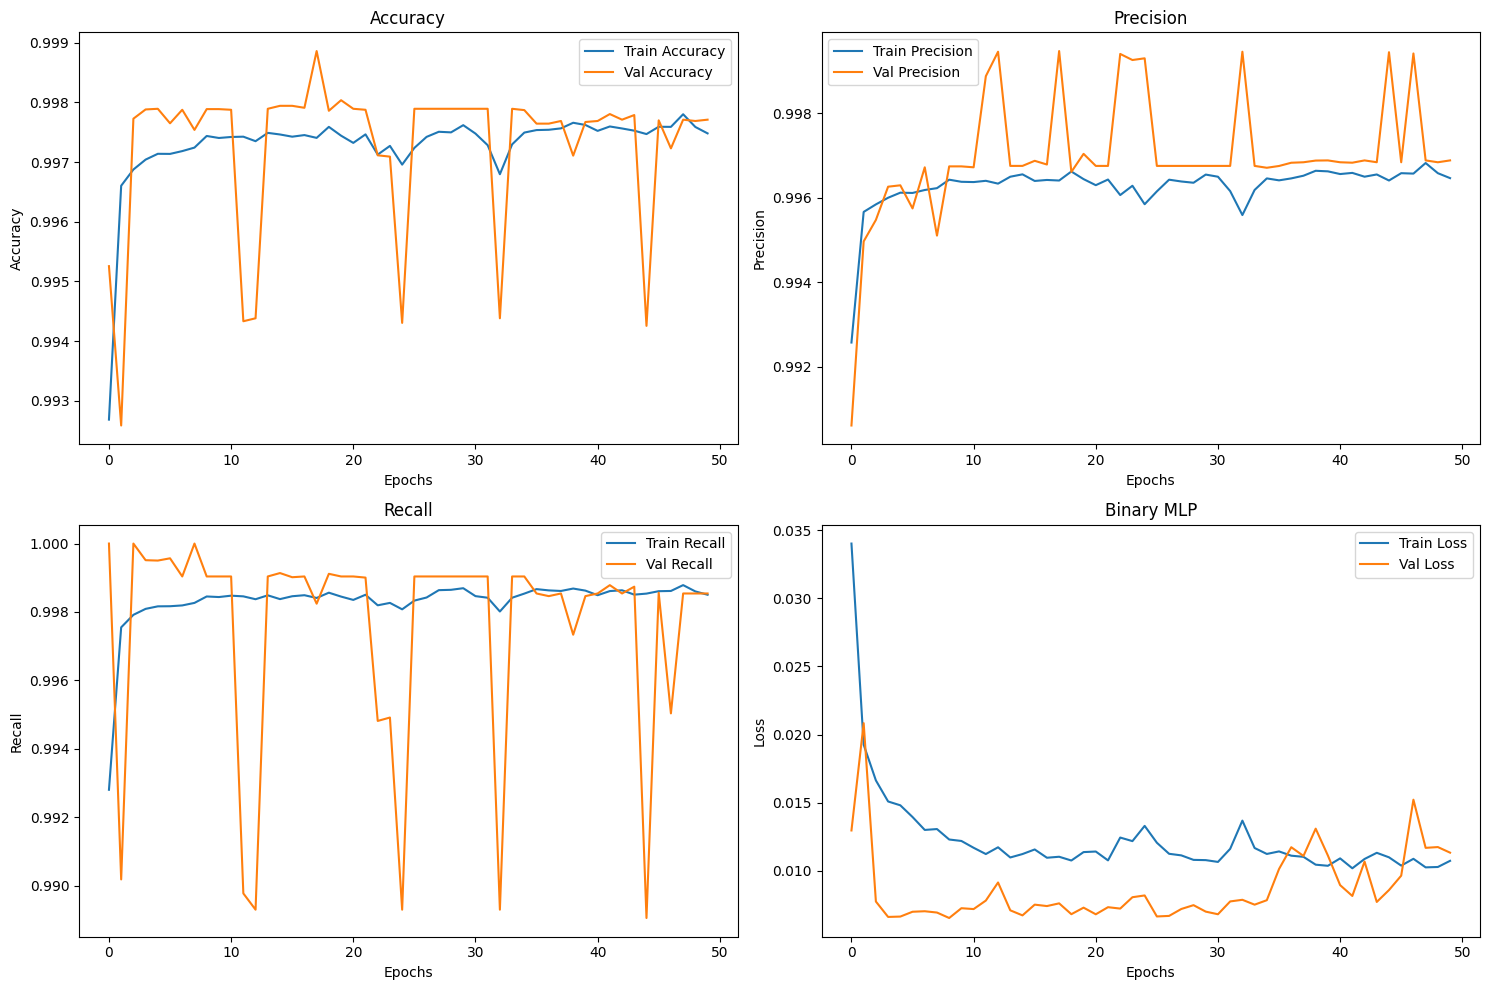

In [9]:
import binary_dnn
import data_utils

bin_dnn_model = binary_dnn.binary_DNN_model()

if not bin_dnn_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_dnn_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=30,
            callbacks = [binary_cnn1d.checkpoint_callback],
        )
    bin_dnn_model.summary()
    print(history.history)
    plot_model_history(history.history, 'Binary MLP')
else:
    # using prior history for plots:
    history = {'accuracy': [0.5039412975311279, 0.519573986530304, 0.537926435470581, 0.5590591430664062, 0.580356240272522, 0.6022741794586182, 0.6226065158843994, 0.6429221034049988, 0.6628920435905457, 0.6822126507759094, 0.6990063786506653, 0.715093731880188, 0.7292599081993103, 0.7431962490081787, 0.7570755481719971, 0.7699145674705505, 0.781755268573761, 0.7921361923217773, 0.8026161193847656, 0.8124735951423645, 0.8222202658653259, 0.8292908072471619, 0.836277425289154, 0.8445358872413635, 0.85130774974823, 0.8582238554954529, 0.8641232252120972, 0.8702356815338135, 0.8761636018753052, 0.8812743425369263], 'f1_score': [0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368], 'loss': [1.1736102104187012, 1.1626096963882446, 1.152018427848816, 1.141636848449707, 1.1313050985336304, 1.1210215091705322, 1.1106278896331787, 1.1001685857772827, 1.0895458459854126, 1.0783287286758423, 1.0669538974761963, 1.0555284023284912, 1.0433945655822754, 1.0309571027755737, 1.0178780555725098, 1.0043110847473145, 0.9899917244911194, 0.9753590226173401, 0.9598010182380676, 0.9438024759292603, 0.926909863948822, 0.9097952246665955, 0.8925130367279053, 0.8737550377845764, 0.854925274848938, 0.8357431292533875, 0.8159001469612122, 0.7963348627090454, 0.7758271098136902, 0.7561131119728088], 'precision': [0.5025191903114319, 0.5131139159202576, 0.526710569858551, 0.543846070766449, 0.5627440214157104, 0.5838282108306885, 0.6053942441940308, 0.6277938485145569, 0.6513332724571228, 0.6750914454460144, 0.6960582137107849, 0.7173850536346436, 0.7369357347488403, 0.7554349303245544, 0.773725152015686, 0.7907701134681702, 0.8066821098327637, 0.8207947611808777, 0.8342835307121277, 0.8466076850891113, 0.8588175177574158, 0.8668254017829895, 0.8744992017745972, 0.8837422132492065, 0.890487790107727, 0.8972713947296143, 0.9027795195579529, 0.9084265828132629, 0.9144765138626099, 0.9190201759338379], 'recall': [0.7861999273300171, 0.7658776044845581, 0.7478774785995483, 0.7325417995452881, 0.7207061648368835, 0.712296724319458, 0.7042630910873413, 0.702112078666687, 0.7010818719863892, 0.7025483250617981, 0.7065248489379883, 0.7098235487937927, 0.7130618095397949, 0.7192397117614746, 0.7266625761985779, 0.7340518832206726, 0.7411156892776489, 0.747468113899231, 0.7552500367164612, 0.7632333040237427, 0.7712233066558838, 0.7781293988227844, 0.7852469086647034, 0.7934516072273254, 0.8011395931243896, 0.8090792298316956, 0.816136360168457, 0.8234820365905762, 0.8299451470375061, 0.8362337946891785], 'val_accuracy': [0.5024603009223938, 0.49962958693504333, 0.5633922219276428, 0.7143757343292236, 0.8583489060401917, 0.8852018713951111, 0.9080299139022827, 0.9251744151115417, 0.9127016663551331, 0.9141612648963928, 0.9181474447250366, 0.9181584715843201, 0.9190928339958191, 0.9190541505813599, 0.8851410150527954, 0.8765051960945129, 0.8785342574119568, 0.8782080411911011, 0.8780642747879028, 0.8791478872299194, 0.8856220245361328, 0.8854727745056152, 0.8854561448097229, 0.8854451179504395, 0.9059068560600281, 0.9131107926368713, 0.9136857986450195, 0.9147915244102478, 0.915001630783081, 0.9156042337417603], 'val_f1_score': [0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368], 'val_loss': [1.161712408065796, 1.1503700017929077, 1.1392860412597656, 1.1284894943237305, 1.1177481412887573, 1.1068445444107056, 1.0957623720169067, 1.0844166278839111, 1.072814702987671, 1.0608230829238892, 1.0483636856079102, 1.0354222059249878, 1.0221866369247437, 1.0084664821624756, 0.9942200779914856, 0.9792265892028809, 0.9634678959846497, 0.9470030665397644, 0.9299129843711853, 0.9121571779251099, 0.8933840990066528, 0.8737546801567078, 0.8536102771759033, 0.8330109715461731, 0.8120672702789307, 0.7908656597137451, 0.7694634199142456, 0.7478134632110596, 0.7260923981666565, 0.7046046257019043], 'val_precision': [0.5012332201004028, 0.49981337785720825, 0.5341836214065552, 0.6398900151252747, 0.7955101132392883, 0.841866135597229, 0.8830288648605347, 0.921779215335846, 0.923231303691864, 0.9512656331062317, 0.9608222842216492, 0.9609693288803101, 0.96262526512146, 0.9623173475265503, 0.9594876170158386, 0.9625478982925415, 0.9702339172363281, 0.9703391194343567, 0.9705097079277039, 0.9705890417098999, 0.971066951751709, 0.9705477356910706, 0.9702799320220947, 0.9702029824256897, 0.9718986749649048, 0.9739195704460144, 0.9745069146156311, 0.9768033027648926, 0.977105438709259, 0.9770644307136536], 'val_recall': [0.9999557733535767, 0.9919944405555725, 0.9906232953071594, 0.9806053042411804, 0.9646715521812439, 0.9485830068588257, 0.9406659007072449, 0.9291993379592896, 0.9002620577812195, 0.8730497360229492, 0.871844470500946, 0.8717228770256042, 0.8720435500144958, 0.8722646832466125, 0.8042393922805786, 0.7834956645965576, 0.7810298800468445, 0.7802669405937195, 0.7798246145248413, 0.7819918990135193, 0.7949290871620178, 0.7950727939605713, 0.7952718734741211, 0.7953161001205444, 0.8359852433204651, 0.8489556312561035, 0.8495969772338867, 0.8497627973556519, 0.8499176502227783, 0.8511891961097717]}
    bin_dnn_model.summary()
    plot_model_history(history, 'Binary MLP')
     

4628/4628 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Accuracy: 0.9750
Precision: 0.9884
Recall: 0.9612
F1 Score: 0.9746


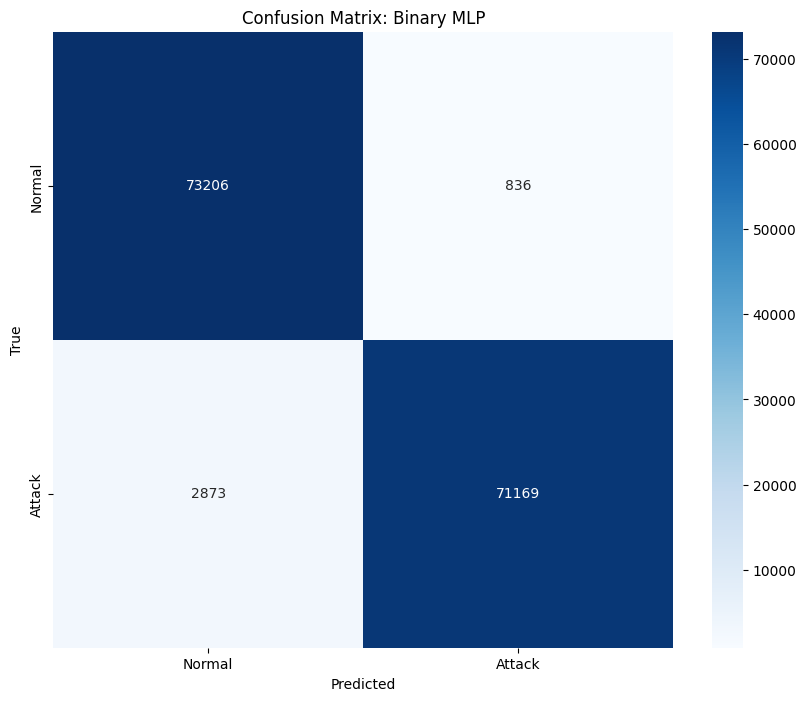

In [10]:
binary_bal_test_ds = data_utils.create_binary_dataset(test_bal_files)
features = []
labels = []

for x, y in binary_bal_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn1d_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_dnn_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary MLP')

In [12]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

bin_arithmetic_mean_aggregate = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_arithmetic_mean_aggregate.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

bin_arithmetic_mean_aggregate.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 1)   │    208,193 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None, 1)   │     18,857 │ input_layer_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None, 1)   │      2,781 │ input_layer_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, None, 1)   │          0 │ sequential[0][0], │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 229,831 (897.78 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 229,831 (897.78 KB)

414/414 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step
Accuracy: 0.9968
Precision: 0.9841
Recall: 0.9988
F1 Score: 0.9914


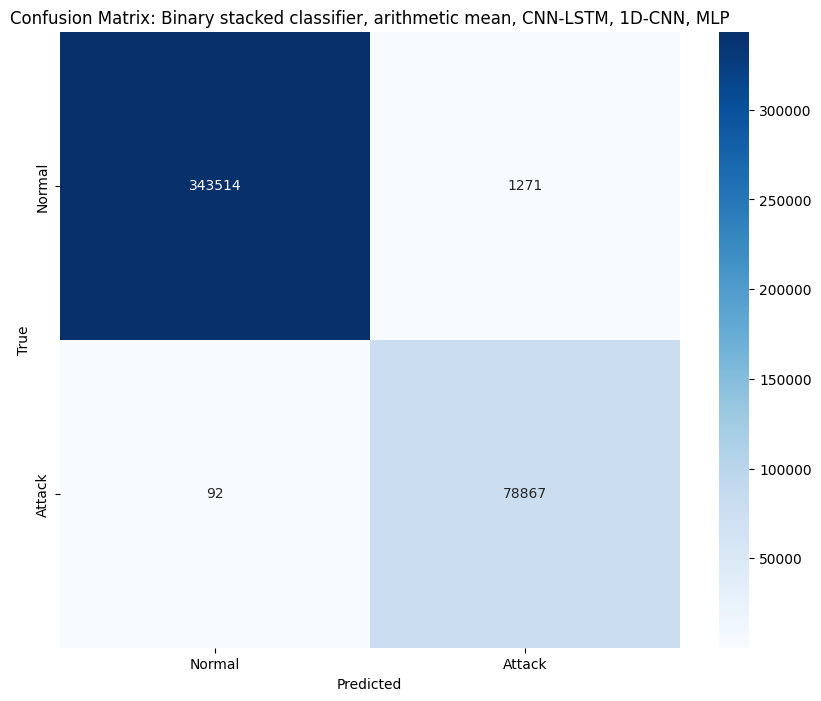

(0.9967834352816795,
 0.9841398587436672,
 0.9988348383338188,
 0.9914328994261362)

In [13]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_arithmetic_mean_aggregate.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, arithmetic mean, CNN-LSTM, 1D-CNN, MLP')

In [16]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

bin_f1_weights = [
    bin_cnn_lstm_metrics[3],
    bin_cnn1d_metrics[3],
    bin_dnn_metrics[3],
]

bin_f1_weights = [math.log(w / (1 - w)) for w in bin_p_weights]

sum_bin_f1_weights = sum(bin_f1_weights)

bin_f1_weights = tf.constant([w / sum_bin_p_weights for w in bin_p_weights], dtype=tf.float32)

print(bin_f1_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_p_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_p_weighted_aggregate = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_p_weighted_aggregate.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

bin_p_weighted_aggregate.summary()

tf.Tensor([0.43111145 0.28444427 0.28444427], shape=(3,), dtype=float32)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 1)   │    208,193 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, None, 1)   │     18,857 │ input_layer_4[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, None, 1)   │      2,781 │ input_layer_4[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, None, 3)   │          0 │ sequential[2][0], │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, None, 3)   │          0 │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 229,831 (897.78 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 229,831 (897.78 KB)

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_p_weighted_aggregate.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, F1  score wheighted mean, CNN-LSTM, 1D-CNN, MLP')

In [ ]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

bin_p_weights = [
    bin_cnn_lstm_metrics[3],
    bin_cnn1d_metrics[3],
    bin_dnn_metrics[3],
]

bin_p_weights = [math.log(w / (1 - w)) for w in bin_p_weights]

sum_bin_p_weights = sum(bin_p_weights)

bin_p_weights = tf.constant([w / sum_bin_p_weights for w in bin_p_weights], dtype=tf.float32)

print(bin_p_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_p_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_p_weighted_aggregate = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_p_weighted_aggregate.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

bin_p_weighted_aggregate.summary()

In [40]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate
input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(combined_output)


bin_stacked_log_regressor = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_stacked_log_regressor.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_log_regressor.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 1)   │    208,193 │ input_layer_13[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_31 │ (None, None, 1)   │     18,857 │ input_layer_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_32 │ (None, None, 1)   │      2,781 │ input_layer_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, None, 3)   │          0 │ sequential[11][0… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_33 │ (None, None, 1)   │          4 │ concatenate_11[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 229,835 (897.79 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 229,831 (897.78 KB)

Epoch 1/2
  18625/Unknown 279s 14ms/step - accuracy: 0.9652 - loss: 0.2773

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18625/18625 ━━━━━━━━━━━━━━━━━━━━ 334s 17ms/step - accuracy: 0.9652 - loss: 0.2773 - val_accuracy: 0.9971 - val_loss: 0.1920
Epoch 2/2
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 290s 16ms/step - accuracy: 0.9979 - loss: 0.1913 - val_accuracy: 0.9970 - val_loss: 0.1921


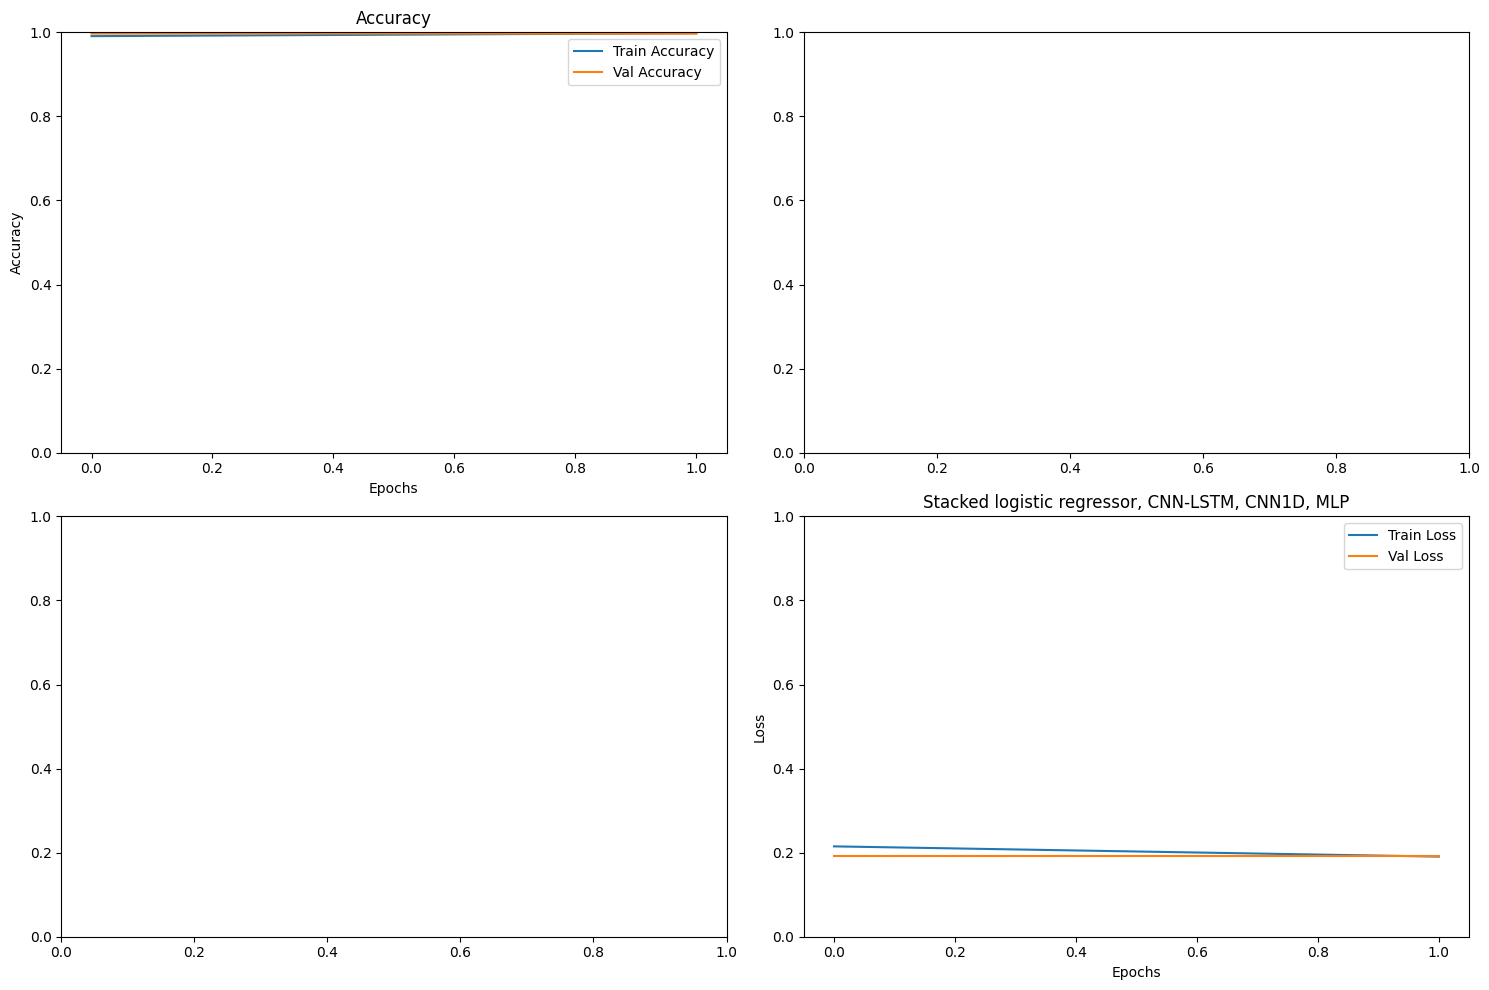

In [41]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_stacked_log_regressor.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Stacked logistic regressor, CNN-LSTM, CNN1D, MLP')

414/414 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step
Accuracy: 0.9974
Precision: 0.9878
Recall: 0.9986
F1 Score: 0.9932


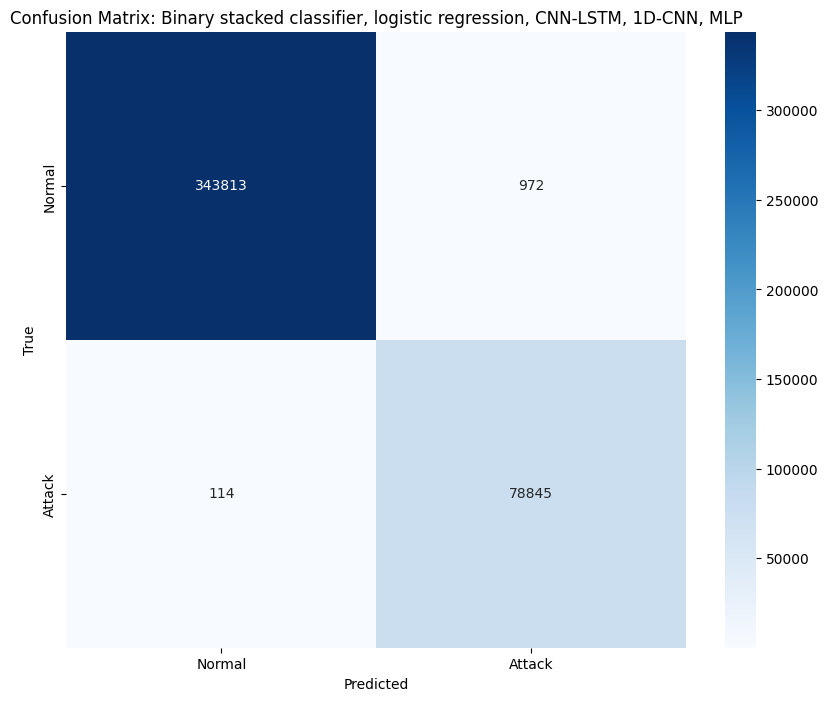

In [42]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_log_regressor.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_stacked_log_regressor_metics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, logistic regression, CNN-LSTM, 1D-CNN, MLP')

In [43]:
output_layer = bin_stacked_log_regressor.layers[-1]
output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights: ", output_weights)
print("Logistic regressor bias: ", output_bias)

In [44]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(combined_output)
y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(y)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)


bin_stacked_dnn_classifier = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_stacked_dnn_classifier.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_dnn_classifier.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 1)   │    208,193 │ input_layer_14[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_34 │ (None, None, 1)   │     18,857 │ input_layer_14[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_35 │ (None, None, 1)   │      2,781 │ input_layer_14[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, None, 3)   │          0 │ sequential[12][0… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_36 │ (None, None, 4)   │         16 │ concatenate_12[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_37 │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_38 │ (None, None, 1)   │          5 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 229,872 (897.94 KB)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 229,831 (897.78 KB)

Epoch 1/5
  18624/Unknown 320s 16ms/step - accuracy: 0.9853 - loss: 0.2260 - precision: 0.9930 - recall: 0.9747

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18625/18625 ━━━━━━━━━━━━━━━━━━━━ 383s 20ms/step - accuracy: 0.9853 - loss: 0.2260 - precision: 0.9930 - recall: 0.9747 - val_accuracy: 0.9968 - val_loss: 0.1196 - val_precision: 0.9965 - val_recall: 0.9972
Epoch 2/5
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 352s 19ms/step - accuracy: 0.9980 - loss: 0.1149 - precision: 0.9970 - recall: 0.9991 - val_accuracy: 0.9970 - val_loss: 0.1195 - val_precision: 0.9964 - val_recall: 0.9976
Epoch 3/5
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 380s 20ms/step - accuracy: 0.9980 - loss: 0.1148 - precision: 0.9968 - recall: 0.9992 - val_accuracy: 0.9968 - val_loss: 0.1196 - val_precision: 0.9965 - val_recall: 0.9971
Epoch 4/5
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 359s 19ms/step - accuracy: 0.9981 - loss: 0.1148 - precision: 0.9971 - recall: 0.9992 - val_accuracy: 0.9967 - val_loss: 0.1198 - val_precision: 0.9965 - val_recall: 0.9969
Epoch 5/5
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 348s 19ms/step - accuracy: 0.9981 - loss: 0.1148 - precision: 0.9970 - recall: 0.9992 - val_accuracy: 0

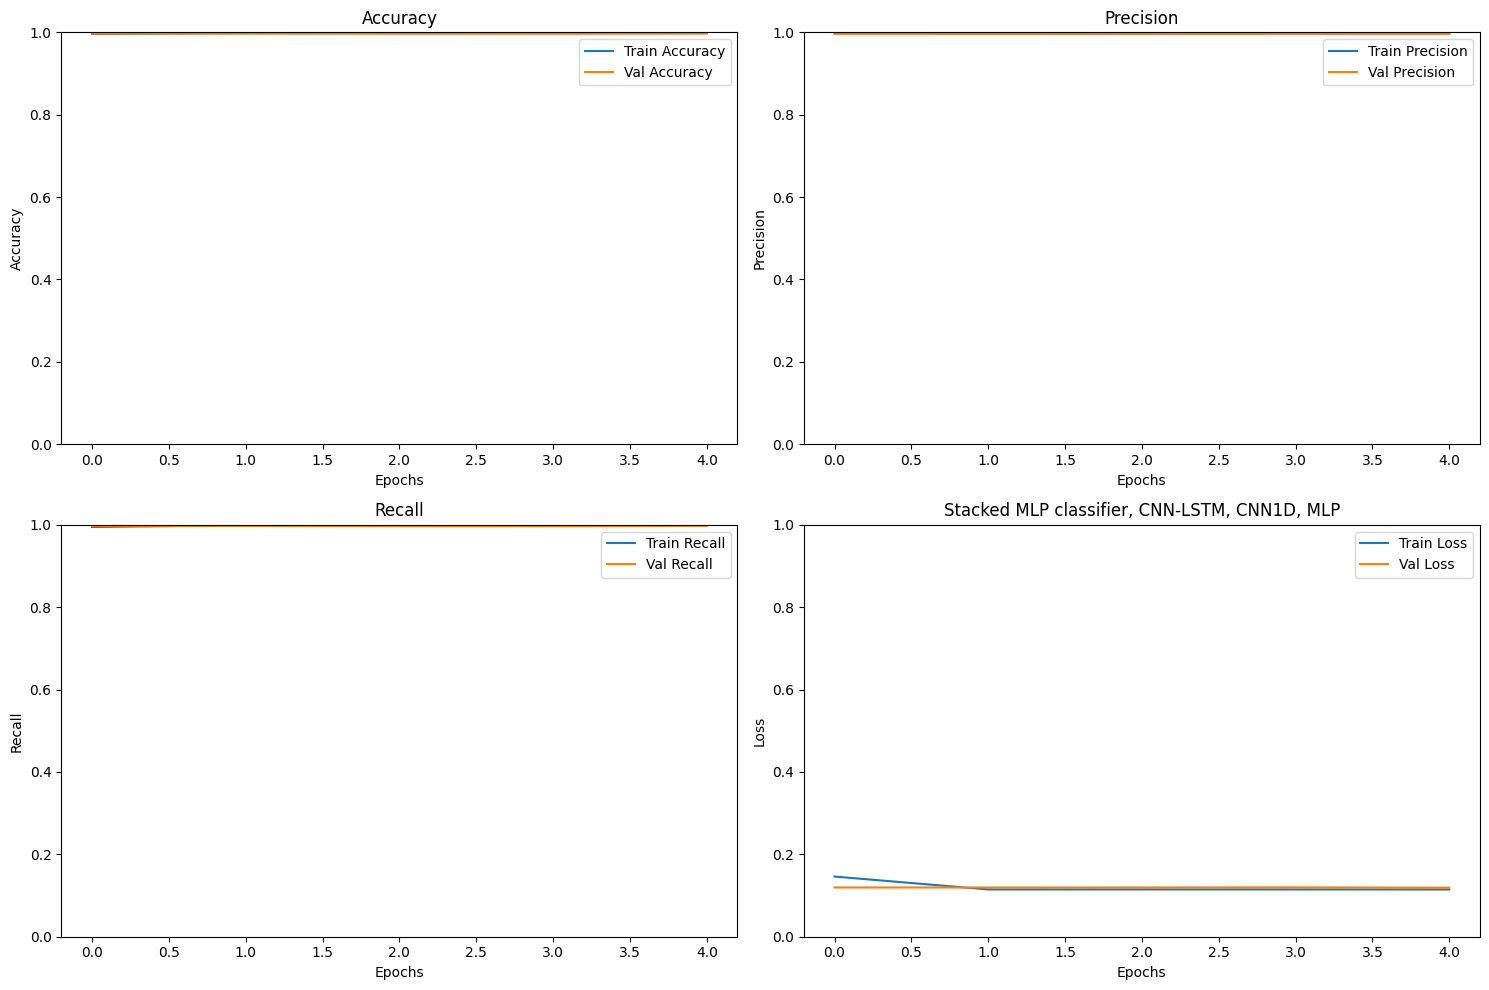

In [45]:
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_stacked_dnn_classifier.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Stacked MLP classifier, CNN-LSTM, CNN1D, MLP')

414/414 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step
Accuracy: 0.9976
Precision: 0.9885
Recall: 0.9986
F1 Score: 0.9935


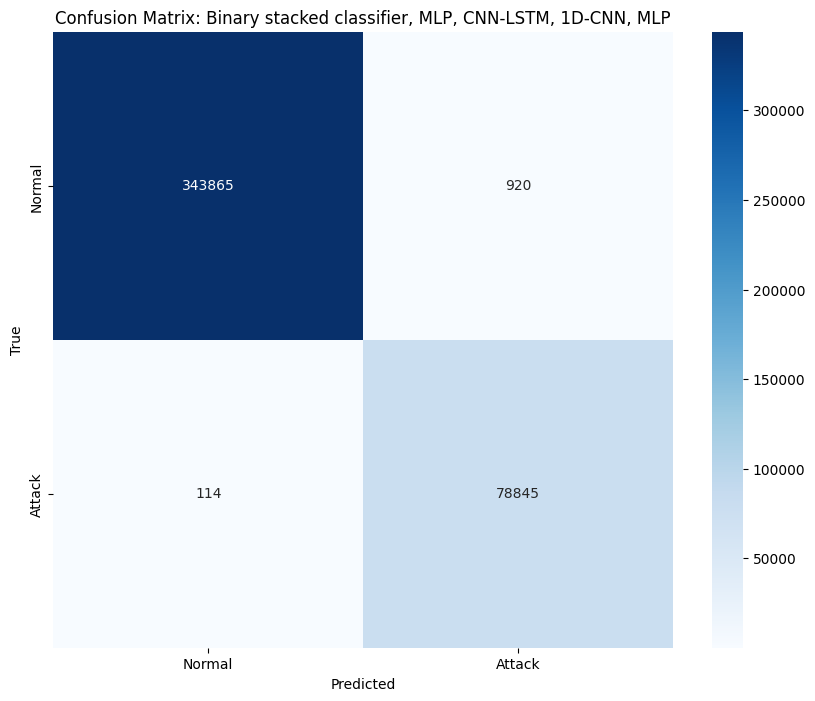

In [46]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_dnn_classifier.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_stacked_dnn_classifier_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, MLP, CNN-LSTM, 1D-CNN, MLP')